In [53]:
%load_ext autoreload
%autoreload 2
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
import clmm, pickle
from copy import deepcopy
from clmm import Cosmology
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
clmm.__version__

'1.10.0'

In [55]:
%load_ext autoreload
%autoreload 2
sys.path.append('../../modules')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [56]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef(200, 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef, )

## Hyper-parameters (non-cosmo)

In [57]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.3), .5
proxy_mu0, proxy_muz, proxy_mulog10m =  3.3459962361884124,0.07801176351746114,2.228300063805894
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.5648876773616248,-0.04290108018727131,0.10256400070211057
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [58]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(12, 16, 300)
z_grid = np.linspace(.2, 1, 300)

# Cluster Abundance

In [59]:
z_edges = z_corner = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
Z_bin = binning(z_edges)
richness_edges = np.array([20, 35, 70, 100, 200])
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [70]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation': 'Duffy08'}
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,
           'compute_dNdzdlogMdOmega_log_slope':True,
           'compute_richness_mass_relation':True, 
           'compute_completeness':True, 'compute_halo_bias':True ,'compute_purity':True }

In [71]:
#compute_count_modeling
%time count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

CPU times: user 2.31 s, sys: 795 ms, total: 3.11 s
Wall time: 3.11 s


In [72]:
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [73]:
Omega = (4*np.pi)
rm = count_modelling_new['richness_mass_relation']
N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = rm, grids = grids)

In [74]:
NLS = Omega * cl_count.Cluster_NHMFLogSlope_ProxyZ(bins, 
                                           integrand_count = rm, 
                                           log_slope = count_modelling_new['dNdzdlogMdOmega_log_slope'][0,:,:], 
                                           grids = grids, 
                                           cosmo = None)
log_slope = (NLS/N)

In [75]:
Ben_ls = np.load('../cluster_scaling_relation_DC2/modules/HMF_Despali16_Payerne_scaling_beta1.pkl', allow_pickle=True)

In [76]:
new_scaling_beta1 = {}
for i in range(7):
    m_fixed = log_slope[:,i]
    for j in range(4):
        new_scaling_beta1[f'richness={Richness_bin[j][0]:.0f}-{Richness_bin[j][1]:.0f}_z={Z_bin[i][0]:.2f}-{Z_bin[i][1]:.2f}'] = m_fixed[j]

In [77]:
#save_pickle(new_scaling_beta1, '../cluster_scaling_relation_DC2/modules/HMF_Despali16_Payerne_scaling_beta1_new.pkl', allow_pickle=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'richness')

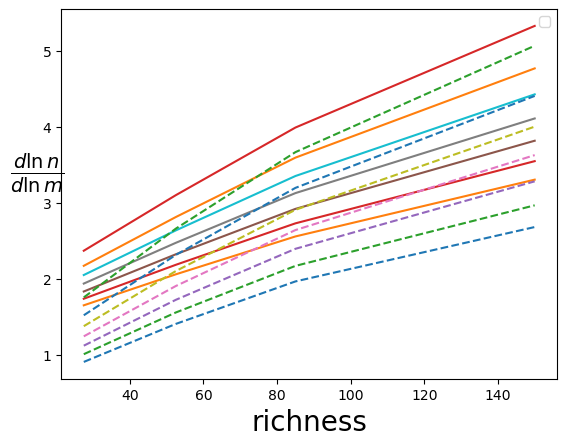

In [78]:
for i in range(7):
    lss_ben = []
    lss_new = []
    for j in range(4):
        lss_ben.append( Ben_ls[f'richness={Richness_bin[j][0]:.0f}-{Richness_bin[j][1]:.0f}_z={Z_bin[i][0]:.2f}-{Z_bin[i][1]:.2f}'])
        lss_new.append( new_scaling_beta1[f'richness={Richness_bin[j][0]:.0f}-{Richness_bin[j][1]:.0f}_z={Z_bin[i][0]:.2f}-{Z_bin[i][1]:.2f}'])
    plt.plot(np.mean(Richness_bin, axis=1), lss_ben, '--')
    plt.plot(np.mean(Richness_bin, axis=1), lss_new, '-')
plt.legend()
plt.ylabel(r'$\frac{d\ln n}{d \ln m}$', fontsize=20, rotation=0)
plt.xlabel('richness', fontsize=20,)